# Importando módulos 

In [23]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal


#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [2]:
FOLDER_OUTPUT = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED_GL_SDS/"

XML_FILE = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/XML/glider_nettab_per_dive.xml'

QUAKEXML_FOLDER = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/EVENTS/'


# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/*.mseed'))

In [4]:
len(filenames_MSEED)

120197

In [5]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [6]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120197/120197 [05:06<00:00, 392.66it/s]


In [7]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [8]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime,format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final


,filename,starttime,endtime
0,GL.G1500..HHH.D.2015.316.13.54.41,2015-11-12 13:54:41,2015-11-12 13:56:40.930
1,GL.G1500..HHH.D.2015.316.13.50.41,2015-11-12 13:50:41,2015-11-12 13:52:40.930
2,GL.G1500..HHH.D.2015.316.13.52.41,2015-11-12 13:52:41,2015-11-12 13:54:40.930
3,GL.G1500..HHH.D.2015.316.13.48.41,2015-11-12 13:48:41,2015-11-12 13:50:40.930
4,GL.G1500..HHH.D.2015.316.14.44.18,2015-11-12 14:44:18,2015-11-12 14:46:17.930
...,...,...,...
120192,GL.G211E..HHH.D.2021.308.06.53.38,2021-11-04 06:53:38,2021-11-04 06:57:21.780
120193,GL.G211E..HHH.D.2021.308.05.43.38,2021-11-04 05:43:38,2021-11-04 05:53:37.990
120194,GL.G211E..HHH.D.2021.308.05.53.38,2021-11-04 05:53:38,2021-11-04 06:03:37.990
120195,GL.G211E..HHH.D.2021.308.06.03.38,2021-11-04 06:03:38,2021-11-04 06:13:37.990


# Extraindo informações do Inventório ".xml"

In [9]:
inv_glider = read_inventory(XML_FILE)

In [10]:
inv_glider

Inventory created at 2024-04-22T22:27:12.431886Z
	Sending institution: scxml import (ObsPy Inventory)
	Contains:
		Networks (1):
			GL
		Stations (45):
			GL.G1500 (RSBR-MAR Station C00:SG618)
			GL.G1601 (RSBR-MAR Station C01:SG618)
			GL.G1602 (RSBR-MAR Station C02:SG612)
			GL.G1604 (RSBR-MAR Station C04:SG612)
			GL.G1605 (RSBR-MAR Station C05:SG612)
			GL.G1606 (RSBR-MAR Station C06:SG612)
			GL.G1607 (RSBR-MAR Station C07:SG612)
			GL.G1608 (RSBR-MAR Station C08:SG612)
			GL.G1709 (RSBR-MAR Station C09:SG612)
			GL.G170A (RSBR-MAR Station C10:SG569)
			GL.G170B (RSBR-MAR Station C11:SG570)
			GL.G170C (RSBR-MAR Station C12:SG569)
			GL.G170E (RSBR-MAR Station C14:SG571)
			GL.G170F (RSBR-MAR Station C15:SG612)
			GL.G170G (RSBR-MAR Station C16:SG612)
			GL.G170H (RSBR-MAR Station C17:SG612)
			GL.G170I (RSBR-MAR Station C18:SG571)
			GL.G170J (RSBR-MAR Station C19:SG612)
			GL.G180K (RSBR-MAR Station C20:SG612)
			GL.G180L (RSBR-MAR Station C21:SG612)
			GL.G180M (RSBR-MAR Statio

In [11]:
df_glider_xml_lst = []
for sta in inv_glider[0]:
    for cha in sta:
        station = sta.code
        latitude = cha.latitude
        longitude = cha.longitude
        depth = cha.depth*(-1)
        starttime = cha.start_date
        endtime = cha.end_date
        df_cha = pd.DataFrame([[station],[latitude],[longitude],[depth],[starttime],[endtime]], index=['station','latitude','longitude','depth','starttime','endtime']).T
        df_glider_xml_lst.append(df_cha)

In [12]:
dataframe_glider_xml = pd.concat(df_glider_xml_lst, ignore_index=True)

In [13]:
dataframe_glider_xml

,station,latitude,longitude,depth,starttime,endtime
0,G1500,-23.8244,-42.4954,-25.43,2015-11-12T13:48:00.000000Z,2015-11-12T13:56:00.000000Z
1,G1500,-23.8166,-42.4944,-49.85,2015-11-12T14:36:00.000000Z,2015-11-12T14:50:00.000000Z
2,G1500,-23.8071,-42.4872,-151.93,2015-11-12T15:35:00.000000Z,2015-11-12T16:15:00.000000Z
3,G1500,-23.7909,-42.4733,-252.44,2015-11-12T17:42:00.000000Z,2015-11-12T18:43:00.000000Z
4,G1500,-23.7852,-42.469,-256.76,2015-11-12T20:43:00.000000Z,2015-11-12T21:47:00.000000Z
...,...,...,...,...,...,...
3772,G211E,-24.3342,-42.434,-472.7,2021-11-02T12:40:00.000000Z,2021-11-02T15:18:00.000000Z
3773,G211E,-24.3568,-42.4256,-480.42,2021-11-03T03:38:00.000000Z,2021-11-03T06:09:00.000000Z
3774,G211E,-24.3784,-42.4306,-477.73,2021-11-03T09:16:00.000000Z,2021-11-03T11:50:00.000000Z
3775,G211E,-24.4377,-42.4649,-434.74,2021-11-04T00:25:00.000000Z,2021-11-04T02:19:00.000000Z


/tmp/ipykernel_118720/118092646.py:56: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,


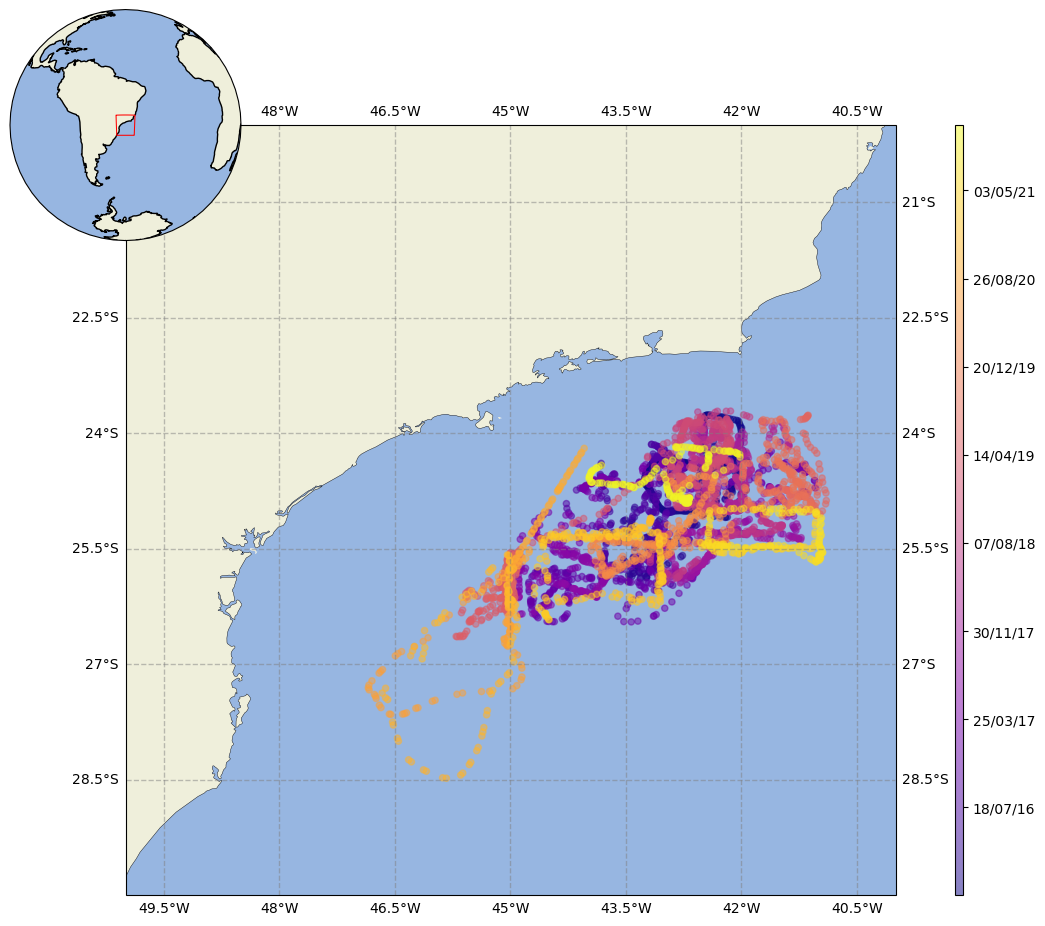

In [14]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=20,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


In [292]:
client = Client("USGS")

t1 = UTCDateTime("2015-11-01T00:00:00")
t2 = UTCDateTime("2021-12-31T23:59:59")
cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=6.0)

In [293]:
cat

840 Event(s) in Catalog:
2021-12-29T18:25:51.962000Z |  -7.548, +127.577 | 7.3  mww | manual
2021-12-26T15:42:57.107000Z | -18.110, -179.352 | 6.1  mww | manual
...
2015-11-07T07:04:31.380000Z | -29.464,  -72.302 | 6.2  mww | manual
2015-11-04T03:44:15.190000Z |  -8.338, +124.875 | 6.5  mww | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

# Selecionando um evento: 

In [291]:
events = glob.glob(QUAKEXML_FOLDER+'*')
print("Found %s event(s)" % len(events))

Found 4 event(s)


In [37]:
events

['/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/EVENTS/quakeml_2017_12_22_argentina.xml',
 '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/EVENTS/quakeml_2020_03_25_costa_brasil.xml',
 '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/EVENTS/quakeml_2017_04_15_chile.xml',
 '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/EVENTS/quakeml_2017_06_14_guatemala.xml']

In [216]:
a = read_events(events[2])[0]
a

Event:	2017-04-15T08:19:43.400000Z | -23.271,  -67.766 | 6.3  Mww

	      resource_id: ResourceIdentifier(id="quakeml:us.anss.org/event/10008hu2")
	       event_type: 'earthquake'
	    creation_info: CreationInfo(agency_id='us', agency_uri=ResourceIdentifier(id="smi:anss.org/metadata/agencyid/us"), creation_time=UTCDateTime(2017, 7, 1, 5, 5, 9))
	             ---------
	 focal_mechanisms: 1 Elements
	          origins: 2 Elements
	       magnitudes: 1 Elements

In [297]:
def event_search(ev_file):

    #ev = read_events(ev_file)[0]
    ev = ev_file
    
    ev_time = ev.origins[0].time
    ev_lat = ev.origins[0].latitude
    ev_long = ev.origins[0].longitude
    ev_depth = ev.origins[0].depth/1000

    file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
    if len(file_mseed_info['filename'].tolist()) > 0:
        name_glider = file_mseed_info['filename'].tolist()[0].split('.')[1]

        # Selecionando no inventório dos glider a localização da estação via ARQUIVO XML:
        inv_sel = inv_glider.select(channel="*H", station=name_glider)
        sta_sel = inv_sel[0][0]
        for cha in sta_sel:
            if (cha.start_date <= ev_time) & (cha.end_date >= ev_time):
                lat_glider = cha.latitude
                lon_glider = cha.longitude
                dep_glider = cha.depth*-1
                time_glider = cha.start_date
                
        #Calculating distance, azimuth and backazimuth
        dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
        gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            
        if gcarc < 100:

                #Calculating ray parameter
                model = TauPyModel(model='iasp91')
                arrivals = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P"])
                arr = arrivals[0]

                arrivalsS = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["S"])
                arrS = arrivalsS[0]
           

                #Reference time
                event = UTCDateTime(ev_time)+arr.time
                eventS = UTCDateTime(ev_time)+arrS.time

                #########################################################################################################################################################
                #STREAM 
                
                file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event.datetime)]

                if len(file_mseed_event) != 0:

                    ev_file_mseed = file_mseed_event['filename'].values[0]
                    file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]
                    
                    stream_mseed = read(file_mseed_ev)
                    stream_mseed = stream_mseed.trim(event-30,event+240)
        
                    lat_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['latitude'].values
                    lon_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['longitude'].values        
                    depth_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['depth'].values       
                    time_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['starttime'].values        


                    #########################################################################################################################################################
                    #Figure 

                    # set up the plot and create a GeoAxes:
                    proj = ccrs.PlateCarree()

                    fig = plt.figure(figsize=(20,20))
                    ax = fig.add_subplot(3, 1, 1, projection=proj)

                    # ----------------------------------------------------------------------------------------------------------
                    # Limit the extent of the map to a small longitude/latitude range.
                    latmin=-27
                    latmax=-22
                    lonmin=-50
                    lonmax=-40

                    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                    # ----------------------------------------------------------------------------------------------------------
                    # Ploting lat/lon values

                    h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding background map 
                    ax.add_feature(cfeature.LAND)
                    ax.add_feature(cfeature.OCEAN)
                    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
                   
                    #Título
                    ax.set_title('Time: '+ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n'+'Distance: '+str(round(dist/1000))+' km'+'\n'+'Magnitude: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type,fontsize=20)
                    
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding colorbar
                    divider = make_axes_locatable(ax)
                    ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                    fig.add_axes(ax_cb)
                    cb = plt.colorbar(h, cax=ax_cb)
                    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                    #####################################################
                    # Adding inset axes RIGHT
                    #####################################################

                    axins = plt.axes([0.31, 0.70, 0.1, 0.1],projection=proj)

                    axins.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.3,cmap='plasma',s=25,transform=proj)
                    axins.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                    axins.add_feature(cfeature.LAND)
                    axins.add_feature(cfeature.OCEAN)
                    axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding grid 
                    axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                    # subregion of the original image
                    x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                    x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                    y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                    y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                    axins.set_xlim(x1, x2)
                    axins.set_ylim(y1, y2)

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding ZOOM
                    ax.indicate_inset_zoom(axins, edgecolor="black")

                    # ----------------------------------------------------------------------------------------------------------
                    ax_histx = plt.axes([0.31, 0.80, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                    ax_histx.scatter(lon_glider,dep_glider, c=np.array(mdates.date2num(time_glider)),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),cmap='plasma',s=100)
                    ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=12)
                    ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                    ax_histx.set_ylim(-1000,0)
                    ax_histx.yaxis.set_major_formatter('{x} m')
                    ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                    ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding global location map
                    # inset location relative to main plot (ax) in normalized units
                    inset_x = 0
                    inset_y = 1
                    inset_size = 0.4

                    # Adding Geoaxes
                    ax_map = plt.axes([0, 0, 0.4, 0.4], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                    ax_map.set_global()

                    # Adding background map 
                    ax_map.add_feature(cfeature.LAND)
                    ax_map.add_feature(cfeature.OCEAN)
                    ax_map.add_feature(cfeature.COASTLINE)

                    # Adding inset geoaxes position
                    ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                            inset_y - inset_size / 2,
                                            inset_size,
                                            inset_size])
                    ax_map.set_axes_locator(ip)


                    # Adding red rectangle position
                    nvert = 100
                    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
                    lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

                    ring = LinearRing(list(zip(lons, lats)))
                    ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                    ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                    ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                    ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding stream plot
                    ax1 = fig.add_subplot(3, 1, 2)
                    ax1_HF = ax1.twinx()

                    st_LF = stream_mseed.copy()
                    st_HF = stream_mseed.copy()
             
                    for tr in st_HF:
                        tr.detrend("linear")
                        tr.taper(max_percentage=0.05, type='cosine')
                        tr.filter('highpass', freq=1, corners=4, zerophase=True)
                        ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> 1 Hz')
                        ax1_HF.legend(loc='lower right', fontsize=10, edgecolor='k', labelcolor='k')   

                    for tr in st_LF:
                        tr.detrend("linear")
                        tr.taper(max_percentage=0.05, type='cosine')
                        tr.filter('lowpass', freq=1, corners=4, zerophase=True)
                        ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< 1 Hz')
                        ax1.legend(loc='lower left', fontsize=10, edgecolor='grey', labelcolor='grey')
                      
                    ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s="$P_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax1.text(x=eventS.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s="$S_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                    ax1.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                    ax1.set_ylabel('Amplitude [counts]')
                    ax1.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])
                    locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                    formatter = mdates.ConciseDateFormatter(locator)
                    ax1.xaxis.set_major_locator(locator)
                    ax1.xaxis.set_major_formatter(formatter)
                    mins2 = SecondLocator(interval=60)
                    mins1 = SecondLocator(interval=10)
                    ax1.xaxis.set_major_locator(mins2)
                    ax1.xaxis.set_minor_locator(mins1)
                    ax1.set_title('Station: '+name_glider)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding spectrogram plot
                    ax2 = fig.add_subplot(3, 1, 3,sharex=ax1)
                    
                    fs = stream_mseed[0].stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                    signal_data = stream_mseed[0].data

                    # Spectrogram
                    frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                    # Plot spectrogram
                    im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                    ax2.xaxis.set_major_locator(locator)
                    ax2.xaxis.set_major_formatter(formatter)
                    # ====================================================================
                    ax2.text(x=event.matplotlib_date,y=45,s="$P_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                    ax2.text(x=eventS.matplotlib_date,y=45,s="$S_{iasp91}$",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax2.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                    ax2.set_ylabel('Frequency [Hz]')
                    # ----------------------------------------------------------------------------------------------------------

                    #colorbar
                    ax_cbar = inset_axes(ax2,
                                        width="7%",  # width = 15% of parent_bbox width
                                        height="2.5%",  # height : 2.5%
                                        loc='upper left',
                                        bbox_to_anchor=(0.0, 0.05, 1, 1),
                                        bbox_transform=ax2.transAxes,
                                        borderpad=0,
                                        )
                    cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')                   

                    # ----------------------------------------------------------------------------------------------------------
                    if len(ev.focal_mechanisms) > 0:

                        newax = fig.add_axes([0.08, 0.5, 0.1,  0.1])
                           
                        np1 = [ev.focal_mechanisms[0].nodal_planes.nodal_plane_1.strike,ev.focal_mechanisms[0].nodal_planes.nodal_plane_1.dip,ev.focal_mechanisms[0].nodal_planes.nodal_plane_1.rake]

                        bball = beach(fm=np1, xy=(0.5, 0.5),size=200, width=0.75, alpha=0.5, facecolor='b')
                        
                        # Configura os eixos e adiciona a coleção
                        newax.add_collection(bball)
                        newax.set_xlim(-1, 1)
                        newax.set_ylim(-1, 1)
                        newax.set_aspect('equal')
                        newax.axis('off')
                    # ----------------------------------------------------------------------------------------------------------
                    # Saving figure
                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_REGIONAL_LOCAL/',exist_ok=True)
                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_REGIONAL_LOCAL/event_mseed_'+event.strftime('%Y_%m_%d_%H_%M_%S')+'_'+ev_file_mseed+'.png')
                    plt.close()

In [298]:
with Pool(processes=8) as p:
    max_ = len(cat)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,cat):
            pbar.update()

  0%|                                                                                                                                 | 0/840 [00:00<?, ?it/s]/tmp/ipykernel_118720/2919372338.py:11: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
/tmp/ipykernel_118720/2919372338.py:11: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (